# 2. Building a machine learning pipeline

## Overview 
Having explored the data and defined the problem, we are ready to build an initial pipeline, with choices informed by our data exploration.

### Prerequisites

* Same as notebook 1 in this tutorial series, plus successful completion of notebook 1

### Learning Outcomes 
* Understand the fundamental steps in a machine learning pipeline
* Understand key terminology in describing the machine learning pipeline
* Initial understanding of how to choose appropriate components for each stage in the pipeline.

### Best Practices & Values

Link to Data Theme
Link to ethics Theme
link to ML lifecycle theme

## Tutorial - Key Elements of a Machine Learning Pipeline

Using a series of data science and machine learning and algorithms to go from input data to a series of predictions is usually referred to as a pipeline.  In this noteboook we will be exploring the key components of such a pipeline in constructing and training a machine learning algorithm with some input data.

In this notebook we will look at 2 pipeline, one for a **supervised** **classification** problem, and the other for an **unsupervised** clustering problem.

The steps we willl go through are as follows:
* *Data Loading & Cleaning* - Start by loading the data, and filtering out any data considered to be unsuitable training and evaluation of machine learning algorithms. Selection of appropriate data is an important way in which domain expertise in vital in getting good results.
* *Feauture Engineering* - The first step is to prepare the data for presenting to the algorithm. Different ways of presenting the data will emphasise different features, and choosing the right features is important for getting good results. Knowledge of what features represent based on domain knowledge is again very important.
* *Train/test Split* - Before we train the algorithm, we need to split into *train* and *test* sets. This is to ensure out algorithm doesn't *overfit*, learning irrelevant details that are not representative of the whole space of possible data, but rather that in generalises well.
* *Data Preparation* - The machine learning algorithm only sees numbers as numbers, with no inherent understnading oif meaning or context. We need to ensure different features are scaled to be comparable, otherwise big numbers will be treated as more important by the algorithm, irrespective of what those numbers mean. Value are typically scaled to a range of `[0,1]` or, assuming a gaussian distribution, to have `mean=0` and `std_dev=1`.
* *Algorithm Setup* - Here we select the particular algorithm e,.g. neural network, k-means clustering, and specify the *hyperparameters*. It is important to distinguish between *parameters* and *hyperparameters*. 
  * Parameters are the values that calculated by the training process. 
  * Hyperparameters are values specified in algorithm setup, which are not altered by training. These need to be fine-tuned using an additional outer training loop called hyperparameter tuning.
* *Algorithm Training* - Execute the algorithm to calculate the best parameters for the chosen ML algorithm to fit the supplied training data
* *Inference* - Once we have an algorithm, we use it to produce predictions, for both the train and test sets.
* *Evaluation* - We then compare the predictions of the trained algorithms to expected results. For supervised learning, this will be supplied target values. For unsupervised learning, we will expplore the results and their usefulness much like in exploratory data analysis.
* *Interpretability & Explainability*  -xxx
* *Model Storage* - Model training can be an expensive process that we don't want to perform too often, and. once we have a model that performs well we save its state so it can be reloaded and used subsequently for inference on later problems.


### Best Practices and Values
The topics covered and the examples demonstrated in this notebook related to the themes of the Met Office machine learning best practices and values in the following ways
* Ethics - Our algorithm development need to be transparent and justifiable.
* Data - We need to consider how we use the data, as well as which data will give us the best results. More data is not always better. Rather select data that is good quality and fits the requirements of the problem
* ML Lifecycle - Ensure we have a reproducible workflow. Save the trained model in a way that can easily bbe reused for inference.
* Interpretability and Explainability - Use a simpler algorithm where possible if this will help exlain and interpret the results
* ML Pitfalls - Ensure the loss function represents the real world requirements and impact of business need to get ML results that deliver value.


### Key Terms

* supervised learning - training an algorithm to map from input to target data or labels.
* unsupervised learning - training an algorithm to find structure in data that has no labels.
* regression - An algorithm that predicts a continuous values.
* classification - An algorithm that predicts from a set of discrete values
* metric - A measure of the performance of the ML algorithm.
* parameter - A value in the algorithm that is determined by the training process e.g. neural network weights or decision tree thresholds.
* hyperparameter - A value in the algorithm that is not determined by training and must be specified or tuned. e.g. number of hidden layers or max number of decision tree levels.
* feature engineering - the process of creating input variables for the ML aglorithm that will give desirable results.
* training set - The subset of your data that you use for training your algorithm.
* validation set - The subset of your data that you use for testing your trained algorithm and which informs subsequent development to improve results.
* test set - The subset of your data that you set aside and do not use while developing the algorithm. Once the development process is finished, you check the final result with this subset of the data to check it truly generalises to unseen data.
* inference - Calculating predictions from input data used a trained algorithm.

More information on jargon
* [Google Machine Learning Glossary](https://developers.google.com/machine-learning/glossary)
* [ML Cheatsheet](https://ml-cheatsheet.readthedocs.io/en/latest/glossary.html)

## Problem 1: Supervised Classification - Falkland Islands Rotor Prediction

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pathlib
import datetime
import os
import functools
import math

In [8]:
import matplotlib
%matplotlib inline

In [9]:
import numpy
import pandas

In [10]:
import iris
import iris.quickplot
import iris.coord_categorisation
import cartopy


In [11]:
import sklearn
import sklearn.neural_network
import sklearn.preprocessing
import sklearn.tree
import sklearn.ensemble
import sklearn.cluster
import sklearn.decomposition

## Load Rotors Data

In [58]:
try:
    falklands_data_dir = os.environ['ML_TUTORIAL_DIR']
except KeyError:
    falklands_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge'
falklands_data_dir = pathlib.Path(falklands_data_dir) 
print(falklands_data_dir)

/Users/stephen.haddad/data/ml_weather_tutorial


In [59]:
print(falklands_data_dir.is_dir())
falklands_data_dir

True


PosixPath('/Users/stephen.haddad/data/ml_weather_tutorial')

In [60]:
falklands_data_fname = '2021_met_office_aviation_rotors.csv'

In [61]:
falklands_data_path = falklands_data_dir / falklands_data_fname

In [62]:
print(falklands_data_path.is_file())
falklands_data_path

True


PosixPath('/Users/stephen.haddad/data/ml_weather_tutorial/2021_met_office_aviation_rotors.csv')

In [63]:
falklands_df = pandas.read_csv(falklands_data_path, header=0).loc[1:,:]

In [64]:
falklands_df = falklands_df.drop_duplicates(subset='DTG')

In [65]:
falklands_df

,Unnamed: 0,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors_present
1,1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,0.0
2,2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,0.0
3,3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,0.0
4,4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,0.0
5,5,01/01/2015 12:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,0.0
20102,20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,0.0
20103,20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,0.0
20104,20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,0.0


In [66]:
falklands_df['time'] = pandas.to_datetime(falklands_df['DTG'])

## Feature Engineering

Having loaded the data, we then do some preprocessing. This includes:
* Specify feature names
* convert wind speed / direction back to u/v wind. This is because these parameters will vary more smoothly for northerly winds, which is the wind we are interested in.
* prepare the target variable, including filling in missing data.

In [67]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'


In [68]:
obs_names = [
    'air_temp_obs',
    'dewpoint_obs',
    'wind_speed_obs',
    'wind_direction_obs',
]

obs_feature_names = [
    'air_temp_obs',
    'dewpoint_obs',
]

In [69]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [70]:
%%time
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_df[u_feature] = falklands_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_df[v_feature] = falklands_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

CPU times: user 11.8 s, sys: 1.74 s, total: 13.6 s
Wall time: 13.9 s


In [71]:
wdn1 = 'wind_direction_obs'
wsn1 = 'wind_speed_obs'
u_feature = u_feature_template.format(level_ix='obs')
obs_feature_names += [u_feature]
falklands_df[u_feature] = falklands_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
v_feature = v_feature_template.format(level_ix='obs')
obs_feature_names += [v_feature]
falklands_df[v_feature] = falklands_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

In [72]:
falklands_df[obs_feature_names]

,air_temp_obs,dewpoint_obs,u_wind_obs,v_wind_obs
1,283.9,280.7,3.852740,-1.402283e+00
2,280.7,279.7,7.700000,4.714890e-16
3,279.8,278.1,7.583020,-1.337091e+00
4,279.9,277.0,6.235383,-3.600000e+00
5,279.9,277.4,7.534421,-4.350000e+00
...,...,...,...,...
20101,276.7,275.5,-3.600000,-6.613093e-16
20102,277.9,276.9,-3.100000,-5.694608e-16
20103,283.5,277.1,-2.314035,-2.757760e+00
20104,286.1,276.9,-3.382893,-1.231273e+00


In [73]:
falklands_df[target_feature_name]  = falklands_df[target_feature_name] .astype(bool)

In [74]:
falklands_df[target_feature_name]

1        False
2        False
3        False
4        False
5        False
         ...  
20101    False
20102    False
20103    False
20104    False
20105    False
Name: rotors_present, Length: 17507, dtype: bool

In [75]:
falklands_df[target_feature_name].value_counts()

False    17058
True       449
Name: rotors_present, dtype: int64

In [76]:
falklands_df.columns

Index(['Unnamed: 0', 'DTG', 'air_temp_obs', 'dewpoint_obs',
       'wind_direction_obs', 'wind_speed_obs', 'wind_gust_obs', 'air_temp_1',
       'air_temp_2', 'air_temp_3',
       ...
       'u_wind_19', 'v_wind_19', 'u_wind_20', 'v_wind_20', 'u_wind_21',
       'v_wind_21', 'u_wind_22', 'v_wind_22', 'u_wind_obs', 'v_wind_obs'],
      dtype='object', length=143)

## Train/test Split

Splitting data into train/validation/test sets

To consider 
* consistency of distributions
* class imbalance
* correlation between samples


An initial option might be to split randomly, using the built-in scikit learn functionality.

In [77]:
test_fraction = 0.2

In [78]:
train_random_df, test_random_df = sklearn.model_selection.train_test_split(falklands_df)
train_random_df.shape, test_random_df.shape

((13130, 143), (4377, 143))

In [79]:
train_random_df[target_feature_name].value_counts()

False    12786
True       344
Name: rotors_present, dtype: int64

In [80]:
test_random_df[target_feature_name].value_counts()

False    4272
True      105
Name: rotors_present, dtype: int64

We know that our 2 classes (rotor detected/ no rotor detected) are imbalanced, so we might want to select from each class, to ensure our train/test splits have distributions which reflect the larger distribution.

In [81]:
num_no_rotors = sum(falklands_df[target_feature_name] == False)
num_with_rotors = sum(falklands_df[target_feature_name] == True)

In [82]:
data_no_rotors = falklands_df[falklands_df[target_feature_name] == False]
data_with_rotors = falklands_df[falklands_df[target_feature_name] == True]

In [83]:
falklands_df['test_set'] = False
falklands_df.loc[list(data_no_rotors.sample(frac=test_fraction).index) + list(data_with_rotors.sample(frac=test_fraction).index),'test_set'] = True

In [84]:
train_class_df = falklands_df[falklands_df['test_set'] == False]
test_class_df = falklands_df[falklands_df['test_set'] == True]

In [85]:
train_class_df[target_feature_name].value_counts()

False    13646
True       359
Name: rotors_present, dtype: int64

In [86]:
test_class_df[target_feature_name].value_counts()

False    3412
True       90
Name: rotors_present, dtype: int64

We also know though that data points from adjacent points in time are likely to be correlated. As a result dfata in our test set will be correlated with that in our train set if we split randomly. Instead for this problem, we should split by time.

In [87]:
train_df = falklands_df[falklands_df['time'] < datetime.datetime(2020,1,1,0,0)]
test_df = falklands_df[falklands_df['time'] > datetime.datetime(2020,1,1,0,0)]

In [88]:
train_df[target_feature_name].value_counts()

False    14273
True       320
Name: rotors_present, dtype: int64

In [89]:
test_df[target_feature_name].value_counts()

False    2784
True      129
Name: rotors_present, dtype: int64

## Data Preparation

In [90]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [91]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(train_df[[if1]])
    preproc_dict[if1] = scaler1

In [92]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(train_df[[target_feature_name]])

LabelEncoder()

In [93]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])


In [94]:
X_train = preproc_input(train_df, preproc_dict)
y_train = preproc_target(train_df, target_encoder)

In [95]:
y_train.shape, X_train.shape

((14593,), (14593, 88))

In [96]:
X_test = preproc_input(test_df, preproc_dict)
y_test = preproc_target(test_df, target_encoder)

In [97]:
y_test.shape, X_test.shape

((2913,), (2913, 88))

In [98]:
train_test_tuples = [
    (X_train, y_train),
    (X_test, y_test),    
]

# Algorithm Setup

In [99]:
classifiers_params = {
    'decision_tree': {'class': sklearn.tree.DecisionTreeClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
    'random_forest': {'class': sklearn.ensemble.RandomForestClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
     'ann_5_500': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(500,500,500,500,500)}},   
     'ann_3_700': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(700,700,700)}},   
}

In [100]:
%%time
classifiers_dict = {}             
for clf_name, clf_params in classifiers_params.items():
    clf1 = clf_params['class'](**clf_params['opts'])
    classifiers_dict[clf_name] = clf1

CPU times: user 65 µs, sys: 1e+03 ns, total: 66 µs
Wall time: 70.1 µs


## Algorithm Training

In [101]:
%%time
for clf_name, clf1 in classifiers_dict.items():
    print(clf_name)
    clf1.fit(X_train, y_train)


decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 42min 35s, sys: 55.7 s, total: 43min 31s
Wall time: 5min 39s


## Inference

In [102]:
y_pred_train = {}

for clf_name, clf1 in classifiers_dict.items():
    y_pred = clf1.predict(X_train)
    y_pred_train[clf_name] = y_pred
    train_df[f'pred_{clf_name}'] = y_pred
    rotors_freq = list(train_df[f'pred_{clf_name}'].value_counts())
    print(f'predicted classes train set: {rotors_freq}')
    actual_freq = list(train_df[target_feature_name].value_counts())
    print(f'actual classes train set: {actual_freq}')

predicted classes train set: [12405, 2188]
actual classes train set: [14273, 320]
predicted classes train set: [12778, 1815]
actual classes train set: [14273, 320]
predicted classes train set: [14287, 306]
actual classes train set: [14273, 320]
predicted classes train set: [14277, 316]
actual classes train set: [14273, 320]


In [103]:
y_pred_test = {}

for clf_name, clf1 in classifiers_dict.items():
    y_pred = clf1.predict(X_test)
    y_pred_test[clf_name] = y_pred
    test_df[f'pred_{clf_name}'] = y_pred
    rotors_freq = list(test_df[f'pred_{clf_name}'].value_counts())
    print(f'predicted classes test set: {rotors_freq}')
    actual_freq = list(test_df[target_feature_name].value_counts())
    print(f'actual classes test set: {actual_freq}')

predicted classes test set: [2478, 435]
actual classes test set: [2784, 129]
predicted classes test set: [2561, 352]
actual classes test set: [2784, 129]
predicted classes test set: [2887, 26]
actual classes test set: [2784, 129]
predicted classes test set: [2868, 45]
actual classes test set: [2784, 129]


## Evaluation

To determine whether the algorithm is performing well, we need to measure the performance in some way. For supervised learning, metrics are divided by the two key types of problem: regression and classification. Whichever sort of algorithm you're using, getting good results depends on measuring the right thing that best reflects the real world impact, business need or physical reality of the system being studied. CHoosing the wrong metric might result in a trained algorithm that seemingly performs well in development, but isn't actually that useful in the real world.

We're dealing with a classification problem here, so we will use classfication relevant metrics.
The obvious metric to use is accuracy i.e. how many predictions did we get right? As we will see, this  usually does represent the way want the algorithm to perform. Obviously we want all the predictions to be correct, but generally, some will be wrong. Depending on the impact of incorrect predictions, we may wish penalise certain mistakes more or less. Different sorts of metrics allow us to do that.
    
A common starting point is precision and recall. This is frequently confusing, and the [wikipedia page](https://en.wikipedia.org/wiki/Precision_and_recall) has numerous useful explanations and diagrams. Precision is the portion of data points predicted as being in a class that are actually in that class. *Recall* in the proportion of data points tat are in a specific class in reality that are predicted as being in that class.
![Precision and recall](images/Precisionrecall.svg)

Graphic taken from Wikipedia


In [104]:
prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
    y_train,
    classifiers_dict['decision_tree'].predict(X_train), 
)

print(f'precision={prec},\n recall={recall},\n f1-score={f1},\n support={support} ')



precision=[0.99983877 0.14533821],
 recall=[0.8689834 0.99375  ],
 f1-score=[0.92982982 0.25358852],
 support=[14273   320] 


Here we see that we have poor precision and good recall from decision tree. This means that we are predicting a high percentage of all actual rotor events, but we are also predicting as rotor events quite a lot of data points that are not actually rotor events.

F1-score combines precision and recall to create a balanced metric. 

$F_{1}= 2 * \frac{precision * recall}{precision + recall}$

The One in the name reflects equal weighting of precision and recall in the metric. We can start to come up with more sophisticated metrics by giving more weight to one or the other, in the $F_{\beta}$ metric

$F_{\beta} = (1 + \beta)^2 * \frac{precision * recall}{\beta^2 *precision + recall}$

Another way to look at the results is using a confusioin matrix, also referenced in the wikipedia page above. 

In [105]:
true_negatives, false_positives, false_negatives, true_positives = sklearn.metrics.confusion_matrix(
    y_train,
    classifiers_dict['decision_tree'].predict(X_train),
).ravel()
true_negatives, false_positives, false_negatives, true_positives

(12403, 1870, 2, 318)

In [106]:
cm1 = sklearn.metrics.confusion_matrix(
    y_train,
    classifiers_dict['decision_tree'].predict(X_train),
)
cm1

array([[12403,  1870],
       [    2,   318]])

The confusion matrix shows us where the algorithm correctly predicts Yes or No for a class, and where it gets it wrong.
* top left = true negative - Model predicts no rotors where none were observed
* top right = false postive (false alarm) - Model predicts rotors where no rotors were observed
* bottom left = false negative (miss) - Model predicts no rotors whererotors were actually observed
* bottom right = true positive (hit) - Model predicts rotors where rotors were observed


We can use this as the basis for other useful metrics. Hit rate is the proportion of data points where rotors were observed where rotors were actually predicted by the algorithm. The higher the hit rate, the more trust there will be in any positive predictions of rotors.

In [107]:
hit_rate = cm1[1,1] / (cm1[1,1]+cm1[1,0])
hit_rate


0.99375

False alarm rate is proportion of data points where no rotors were observed where the model incorrectly predicted rotors.

In [108]:
false_alarm_rate = cm1[0,1] / (cm1[0,1]+cm1[0,0])
false_alarm_rate

0.13101660477825264

The question then, is what do we really care about in this problem? What sort of errors are the most impactful? In our case, it is very important not to miss any rotor events, so false neagatives are very bad and should be penalised. False positive errode trust in the forecast, but it is less costly to predict a few events that don't happen than to miss any events at all. So we might consider the False Alarm and the Miss rate to be very important.

In [109]:
metrics1 = []
for X1, y1 in train_test_tuples:
    md1 = {'classifier': [],
           'precision_noRotor': [], 'precision_rotor': [],
           'recall_noRotor': [], 'recall_rotor': [], 
           'f1_noRotor': [], 'f1_rotor': [], 
           'hit_rate': [], 'false_alarm_rate': []
          }
    for clf_name, clf1 in classifiers_dict.items():
        md1['classifier'] += [clf_name]
        prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(clf1.predict(X1), y1)
        md1['precision_noRotor'] += [prec[0]]
        md1['precision_rotor'] += [prec[1]]
        md1['recall_noRotor'] += [recall[0]]
        md1['recall_rotor'] += [recall[1]]
        md1['f1_noRotor'] += [f1[0]]
        md1['f1_rotor'] += [f1[1]]
        cm1 = sklearn.metrics.confusion_matrix(clf1.predict(X1), y1)
        hit_rate = cm1[1,1] / (cm1[1,1]+cm1[1,0])
        md1['hit_rate'] += [hit_rate]
        false_alarm_rate = cm1[0,1] / (cm1[0,1]+cm1[0,0])
        md1['false_alarm_rate'] += [false_alarm_rate]
    metrics1 += [md1]

In [110]:
train_metrics_df = pandas.DataFrame(metrics1[0])
test_metrics_df = pandas.DataFrame(metrics1[1])

<Axes: title={'center': 'false alarm rate (test) for rotors present class'}, xlabel='classifier'>

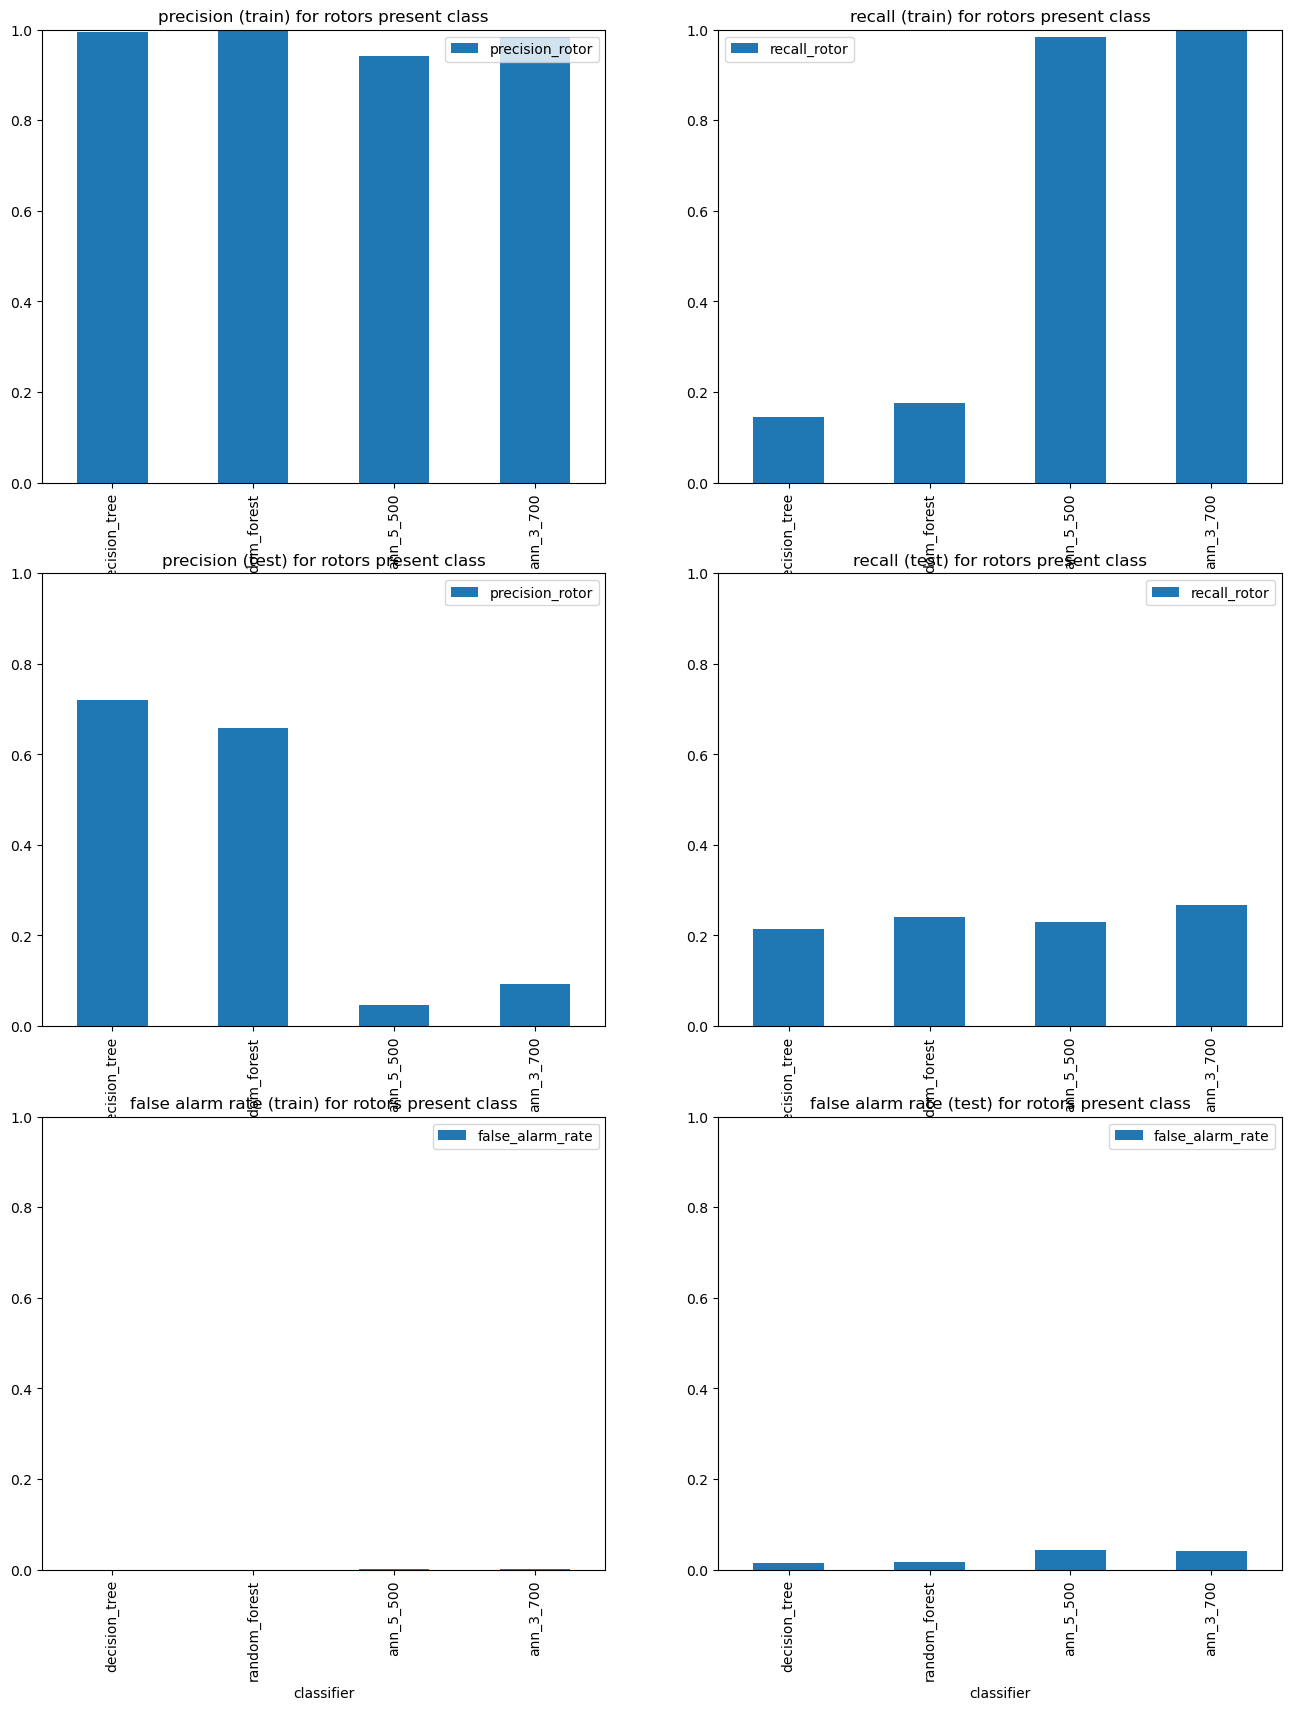

In [111]:
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (test) for rotors present class')
test_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (test) for rotors present class')
test_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (test) for rotors present class')
test_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

In [112]:
def calc_sedi(conf_mat):
    hr1 = conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])
    fa1 = conf_mat[0,1] / (conf_mat[0,0] + conf_mat[0,1])
    sedi_score1 = (
        (numpy.log(fa1) - numpy.log(hr1) - numpy.log(1.0-fa1) + numpy.log(1.0-hr1) )
        / (numpy.log(fa1) + numpy.log(hr1) + numpy.log(1.0 - fa1) + numpy.log(1.0-hr1) )  )
    return sedi_score1

How though do we actually go about getting better results? One way for this is to understand that some algorithms output a pseudo-probability, and the classification is based on thesholding that value. By altering the threshold we get different predictions and thus different metric results.

In [113]:
y_train_pred_raw = classifiers_dict['random_forest'].predict_proba(X_train)[:,1]
y_test_pred_raw = classifiers_dict['random_forest'].predict_proba(X_test)[:,1]

In [114]:
thresholds_list = list(numpy.arange(1e-3,0.995,5e-3))
hit_rates = []
hit_rates_test = []
false_alarm_rates = []
false_alarm_rates_test = []
sedi_list = []
sedi_list_test = []
for threshold in thresholds_list:
    y_pred_train = list(map(float, y_train_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train, y_pred_train)
    hit_rates += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list += [calc_sedi(cm1)]

    y_pred_test = list(map(float, y_test_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_test, y_pred_test)
    hit_rates_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_test += [calc_sedi(cm1)]

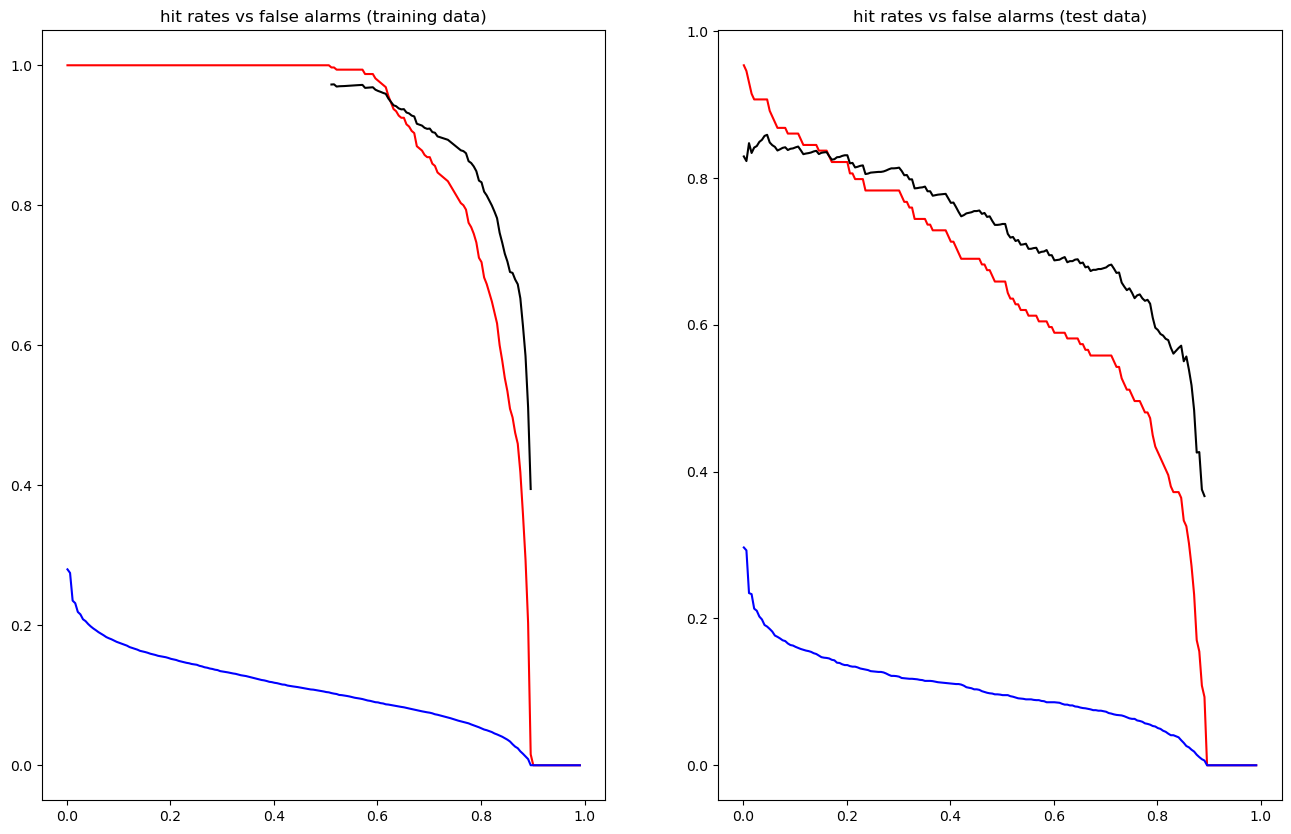

In [115]:
f1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='hit rates vs false alarms (training data)')
ax1.plot(thresholds_list, hit_rates,'r')
ax1.plot(thresholds_list, false_alarm_rates,'b')
ax1.plot(thresholds_list, sedi_list,'k')

ax1 = f1.add_subplot(1,2,2,title='hit rates vs false alarms (test data)')
ax1.plot(thresholds_list, hit_rates_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_test,'b')
ax1.plot(thresholds_list, sedi_list_test,'k')

## Model Storage
Once we have trained a model, we usually want to save the result for subsequent use in scientific work. There a re a variety of ways of doing this. The most simple way in scikit learn is to pickle the data

discuss what elements need to be stored.

In [116]:
import pickle
import tempfile

In [117]:
rf_str = pickle.dumps(classifiers_dict['random_forest'])
rf_str[:20]

b'\x80\x04\x95%\x17\x01\x00\x00\x00\x00\x00\x8c\x18sklearn'

In [118]:
with tempfile.TemporaryDirectory() as td1:
    with open(pathlib.Path(td1) / 'my_trained_classifier.pkl','wb') as clf_file_out1:
        clf_file_out1.write(rf_str)
    with open(pathlib.Path(td1) / 'my_trained_classifier.pkl','rb') as clf_file_in1:
        train_clf_str1 = clf_file_in1.read()

In [119]:
loaded_rf_clf = pickle.loads(train_clf_str1)
loaded_rf_clf

RandomForestClassifier(class_weight='balanced', max_depth=10)

In [120]:
loaded_rf_clf.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

There are more sophisticated ways to do this.
* [Tensorflow](https://www.tensorflow.org/guide/keras/save_and_serialize) has a more roust custom format for saving and loading models.
* [ONNX](https://onnx.ai/) - A library to save models and perform inference
* [ML Flow Models](https://www.mlflow.org/docs/latest/models.html) - Another library that can save models and do inference

## Problem 2 - Clustering weather types from ERA5

So far we have looked an example of *supervised learning*, where we want to predict some target values from input values, which is what we call *labelled data*. Labelling is an expensive process, and where possible it is very useful to be able to find strcuture and patterns in unlabelled data. This can be particularly helpful to explore the data and find structures, as well as providing an approach to perform useful operations without the expense of labelling data.

### Loading the data

In [121]:
try:
    era5_root = os.environ['ML_TUTORIAL_DIR']
except KeyError:
    era5_root = '/project/informatics_lab/data_science_cop/era5/'
era5_data_dir = pathlib.Path(era5_root) 
print(era5_data_dir)

/Users/stephen.haddad/data/ml_weather_tutorial


In [122]:
era5_mslp_path = era5_data_dir / 'era5_mslp_UK_2017_2020.nc'
print(era5_mslp_path)
era5_mslp_path.is_file()

/Users/stephen.haddad/data/ml_weather_tutorial/era5_mslp_UK_2017_2020.nc


True

In [123]:
era5_mslp_cube = iris.load_cube(str(era5_mslp_path))

In [124]:
iris.coord_categorisation.add_season_number(era5_mslp_cube, 'time')

In [125]:
era5_mslp_cube

Air Pressure At Mean Sea Level (Pa),time,latitude,longitude
Shape,35064,101,81
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
season_number,x,-,-
Attributes,,,Conventions CF-1.7institution ECMWFnameCDM Mean_sea_level_pressure_surfacenameECMWF Mean sea level pressureproduct_type analysisshortNameECMWF mslsource Reanalysis


### Preprocessing features

In this case, we previously did some preprocessing from the raw ERA5 data to prepare for our purposes. So far we have:
* Load MLSP data (hourly, global)
* Extract UK area from global ERA5 data

Next up we want to remove the seasonal averages, so that we can get season independent clusters of weather type which will be applicable all year round.


In [126]:
season_average = [era5_mslp_cube.extract(iris.Constraint(season_number=sn1)).collapsed(['time'],iris.analysis.MEAN).data for sn1 in range(4)]

In [127]:
%%time
era5_flat_deseasoned = numpy.concatenate(
    [(era5_mslp_cube.extract(iris.Constraint(season_number=sn1)).data - season_average[sn1]).reshape(
    (-1, era5_mslp_cube.shape[1] * era5_mslp_cube.shape[2])) for sn1 in range(4)],
    axis=0
)

CPU times: user 3.48 s, sys: 3.61 s, total: 7.09 s
Wall time: 5.91 s


In [128]:
era5_mslp_cube.shape

(35064, 101, 81)

In [129]:
era5_flat_deseasoned.shape

(35064, 8181)

### Setup and train the algorithm
Now that we have our data, we want to do some clustering. Scikit learn give a [good overview to clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html), though tis covers only what is available in sklearn many other more advanced lagorithms and implementations are available.

We will use the basic [K-means algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans). This algorithm works as follow:
1. randomly select n points, where n is the desired number of clusters (a hyperparameter)
2. initiate clusters with each of the selected points the centre of a cluster
3. for each point in the dataset, find the closest cluster centre and assign to that cluster
4. for each of the clusters, find the centroid of all the points assigned to that cluster (or the nearest actual point to the centroid).
5. assign those points as the new cluster centres, and repeat from point 3.

In [130]:
num_clusters = 10
max_iter=1000

In [131]:
kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters, random_state=0, max_iter=max_iter)
kmeans

KMeans(max_iter=1000, n_clusters=10, random_state=0)

In [132]:
%%time
kmeans.fit(era5_flat_deseasoned)

CPU times: user 15min 48s, sys: 29.9 s, total: 16min 18s
Wall time: 2min 20s


KMeans(max_iter=1000, n_clusters=10, random_state=0)

### Inference and Evaluation
In this case, we don't have a target to compare our results to


In [133]:
cluster_coord = iris.coords.DimCoord(list(range(10)),
                                     var_name='cluster_number')

In [134]:
cluster_centres = iris.cube.Cube(
    data=kmeans.cluster_centers_.reshape((10,era5_mslp_cube.shape[1],era5_mslp_cube.shape[2],)),
    dim_coords_and_dims = [(cluster_coord, 0), (era5_mslp_cube.coord('latitude'),1), (era5_mslp_cube.coord('longitude'),2)],
    units=era5_mslp_cube.units,
    var_name='cluster_mean_sea_level_pressure',
)
    

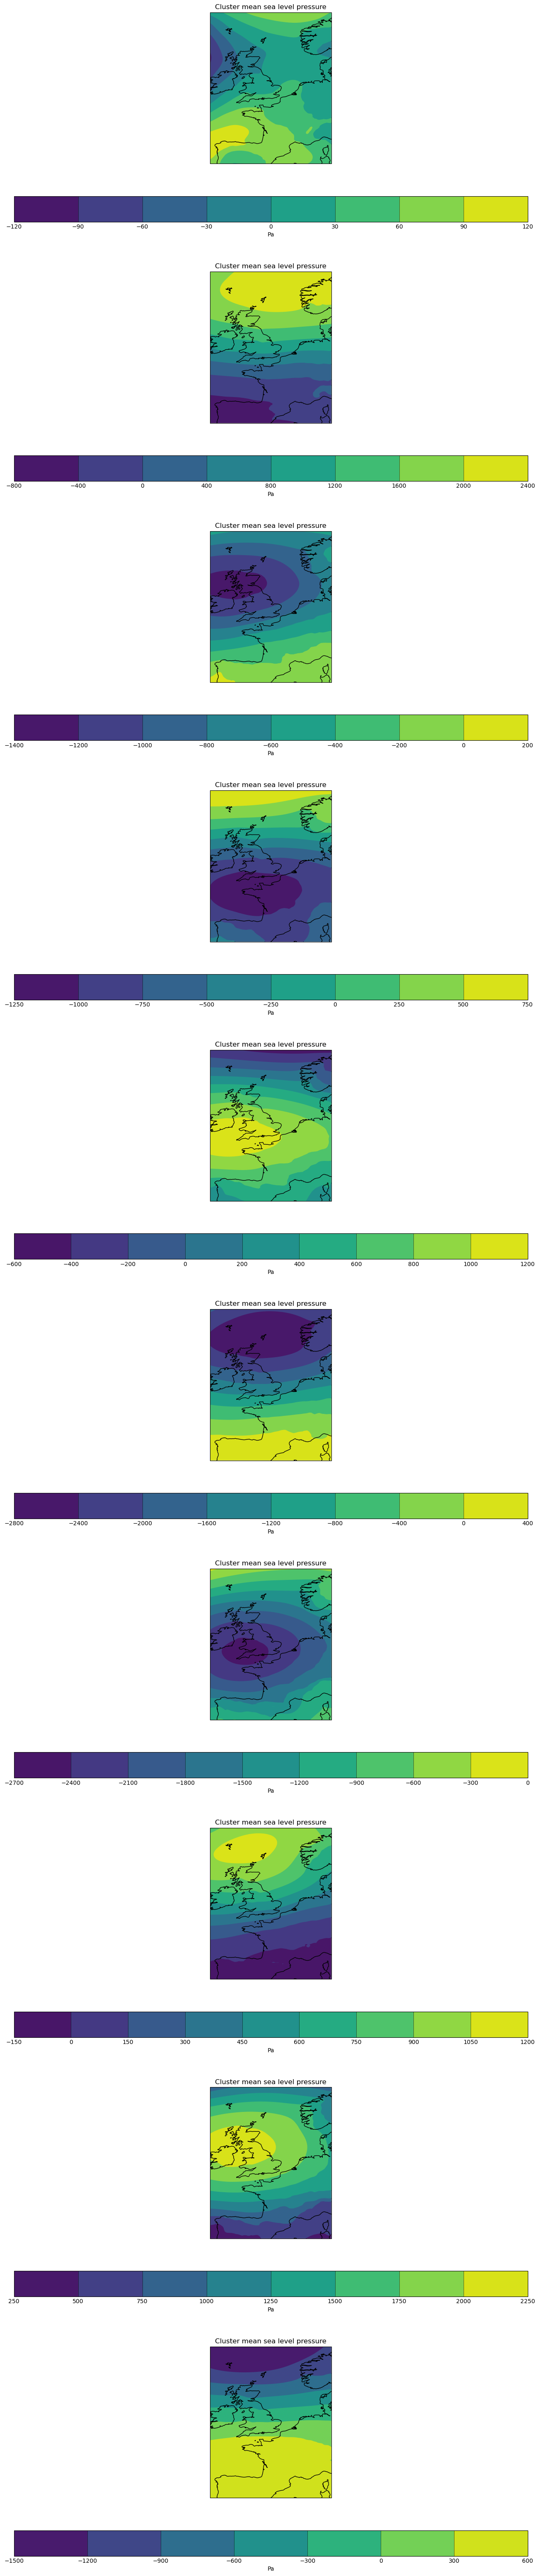

In [135]:
fig1 = matplotlib.pyplot.figure(figsize=(16,80))
for ix1 in range(num_clusters):
    ax1 = fig1.add_subplot(num_clusters,1,ix1+1,projection=cartopy.crs.PlateCarree())
    iris.quickplot.contourf(cluster_centres[ix1,:,:],axes=ax1)
    ax1.coastlines()    
    

In [136]:
season_clusters = [kmeans.predict(
    (era5_mslp_cube.extract(iris.Constraint(season_number=sn1)).data - season_average[sn1]).reshape(
    (-1, era5_mslp_cube.shape[1] * era5_mslp_cube.shape[2])) 
) for sn1 in range(4)]

In [137]:
season_names =['dfj (nh winter)', 'mam (nh spring)', 'jja (nh summer)','son (nh autumn)']

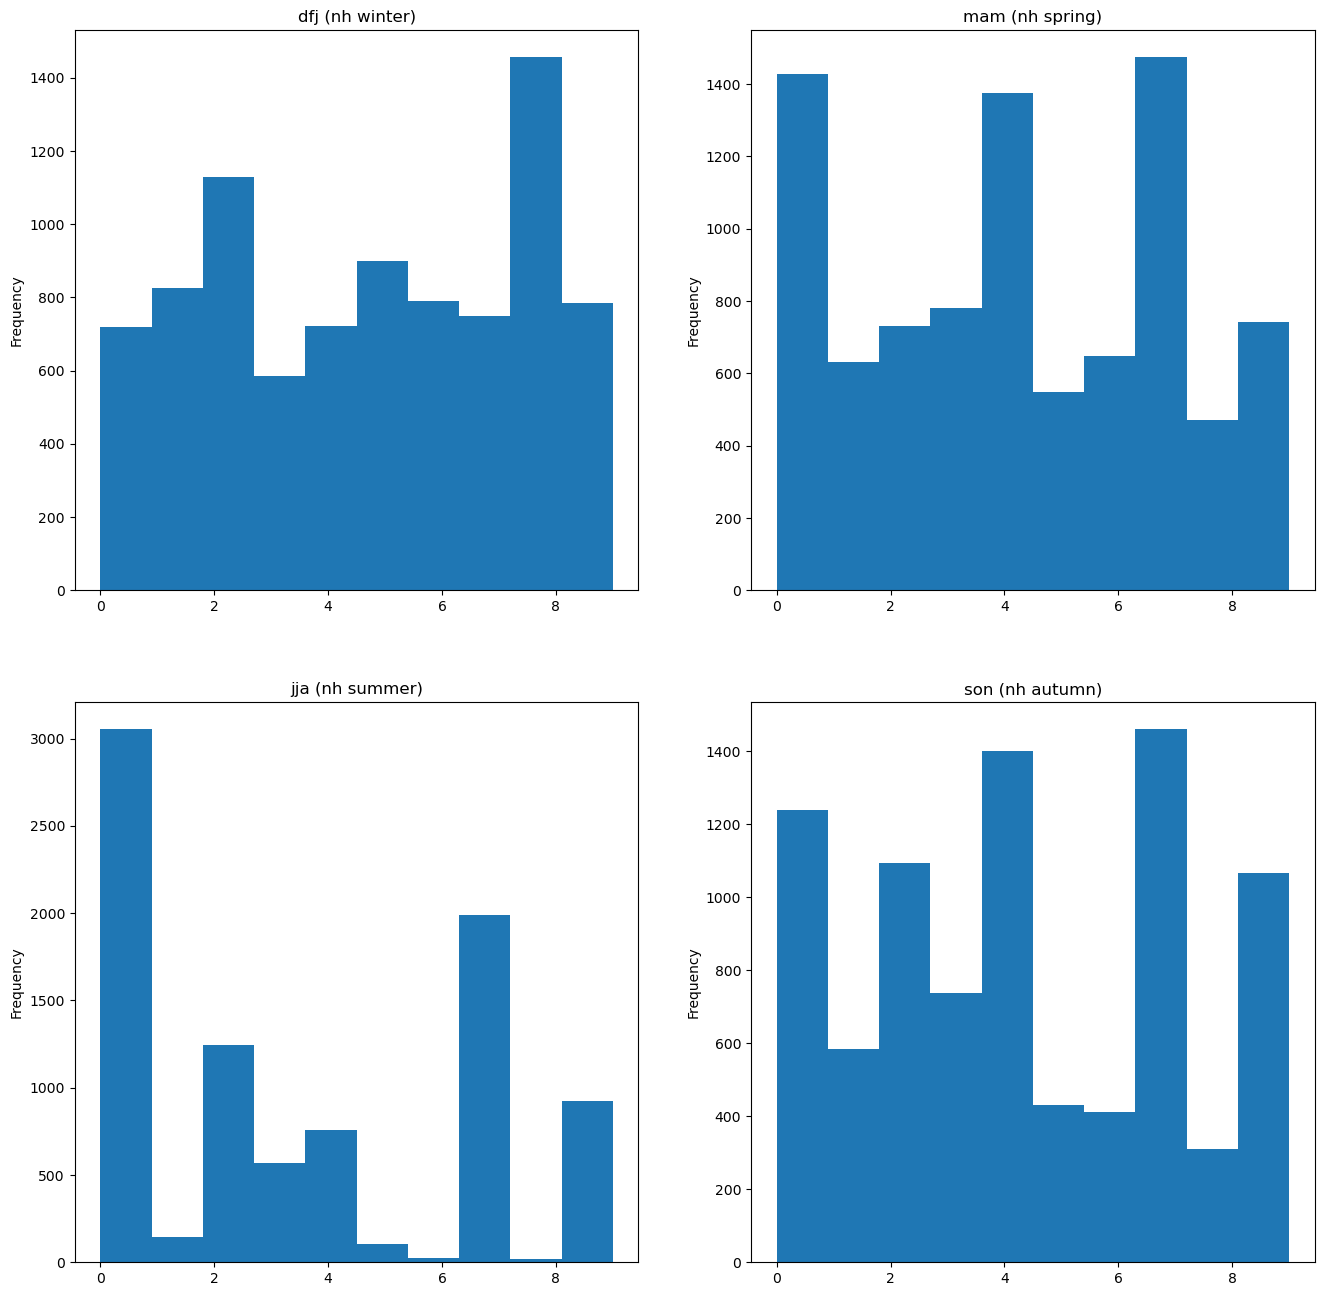

In [138]:
fig1 = matplotlib.pyplot.figure(figsize=(16,16))
for sn1, current_season in enumerate(season_clusters):
    ax1 = fig1.add_subplot(2,2,sn1+1, title=season_names[sn1])
    pandas.Series(current_season).plot.hist(ax=ax1)
    

### Another apporach - dimensionality reduction

To improve clustering reasults, there are various ways of improving
* change how to describe clusters
* change how to assign cluster membership
  * change the distance metric between points
* transform the points into a different space, whcih may preseve some properties and change others, hopefuly to improve separation.  

We will demonstrate this briefly by performing *pincipal component analysis* or *PCA*  on the data to reduce the dimensionality. This will also speed up calculation.

Scikit Learn reference:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [139]:
%%time 
pca_mslp = sklearn.decomposition.PCA(n_components=50, svd_solver='full')
pca_mslp.fit(era5_flat_deseasoned)

CPU times: user 17min 4s, sys: 22.4 s, total: 17min 26s
Wall time: 2min 28s


PCA(n_components=50, svd_solver='full')

In [140]:
era5_dim_reduced = pca_mslp.transform(era5_flat_deseasoned)

In [141]:
%%time
kmeans_mslp_reduced = sklearn.cluster.KMeans(n_clusters=num_clusters, random_state=0, max_iter=max_iter)
kmeans_mslp_reduced.fit(era5_dim_reduced)

CPU times: user 15.9 s, sys: 549 ms, total: 16.5 s
Wall time: 2.18 s


KMeans(max_iter=1000, n_clusters=10, random_state=0)

In [142]:
cluster_centres_pca = iris.cube.Cube(
    data=(pca_mslp.inverse_transform(kmeans_mslp_reduced.cluster_centers_)).reshape((10,era5_mslp_cube.shape[1],era5_mslp_cube.shape[2],)),
    dim_coords_and_dims = [(cluster_coord, 0), (era5_mslp_cube.coord('latitude'),1), (era5_mslp_cube.coord('longitude'),2)],
    units=era5_mslp_cube.units,
    var_name='cluster_mean_sea_level_pressure',
)
    
    

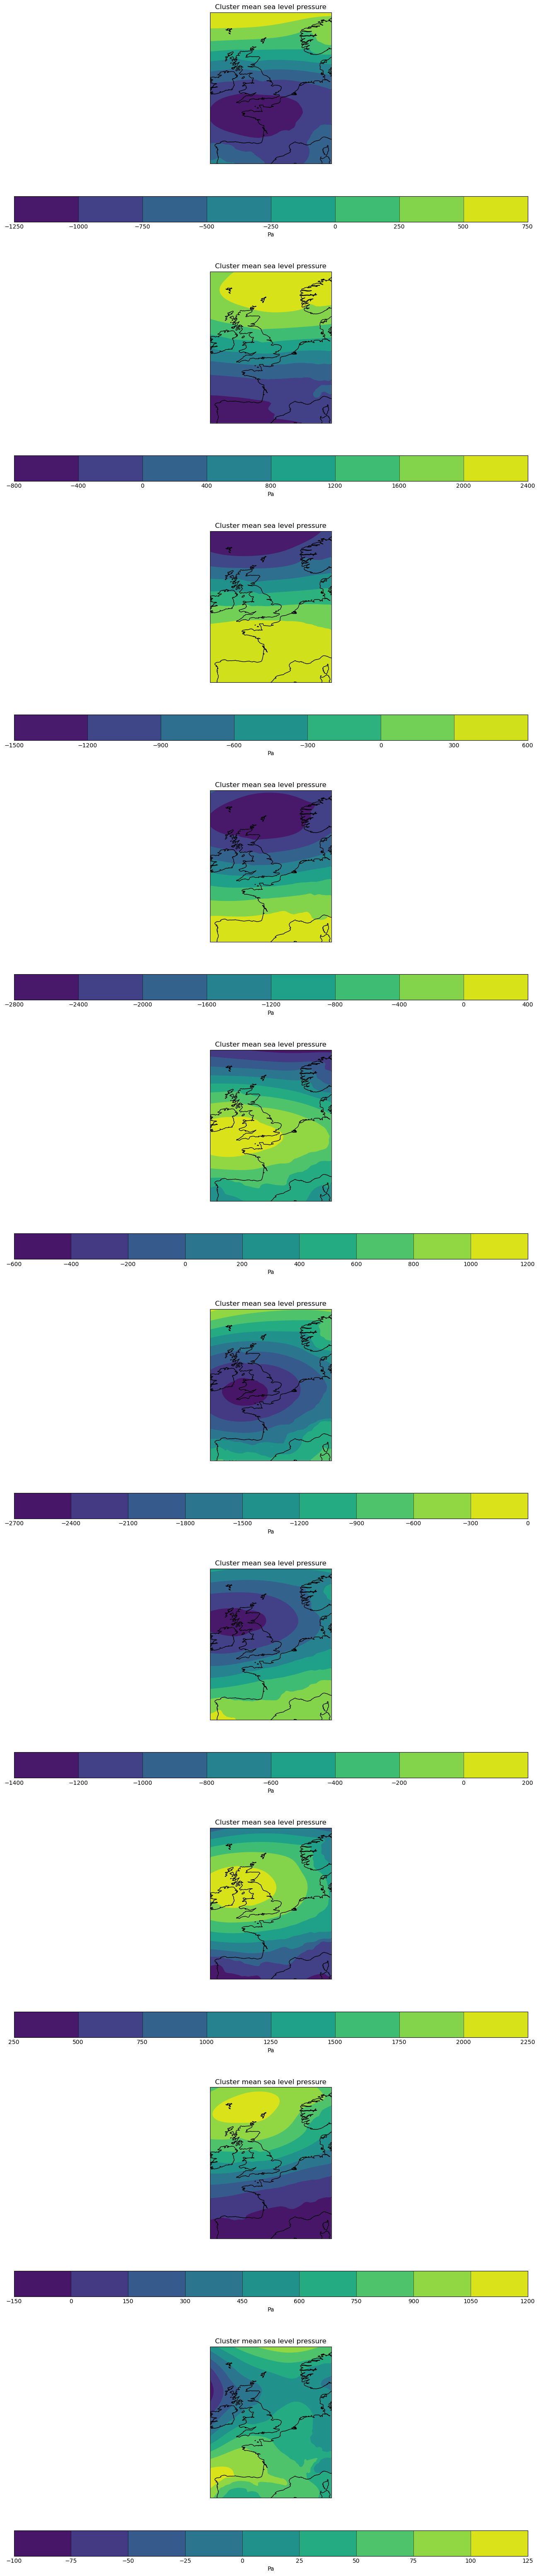

In [143]:
fig1 = matplotlib.pyplot.figure(figsize=(16,80))
for ix1 in range(num_clusters):
    ax1 = fig1.add_subplot(num_clusters,1,ix1+1,projection=cartopy.crs.PlateCarree())
    iris.quickplot.contourf(cluster_centres_pca[ix1,:,:],axes=ax1)
    ax1.coastlines()    


Now to calculate the clusters for each point we perform the following:
* remove the seasonal mean
* reshape the data
* apply PCA transform to reduce dimensionality
* predict which cluster each point belongs to

In [144]:
season_clusters_pca = [kmeans_mslp_reduced.predict( pca_mslp.transform(
    (era5_mslp_cube.extract(iris.Constraint(season_number=sn1)).data - season_average[sn1]).reshape(
    (-1, era5_mslp_cube.shape[1] * era5_mslp_cube.shape[2]))) 
) for sn1 in range(4)]

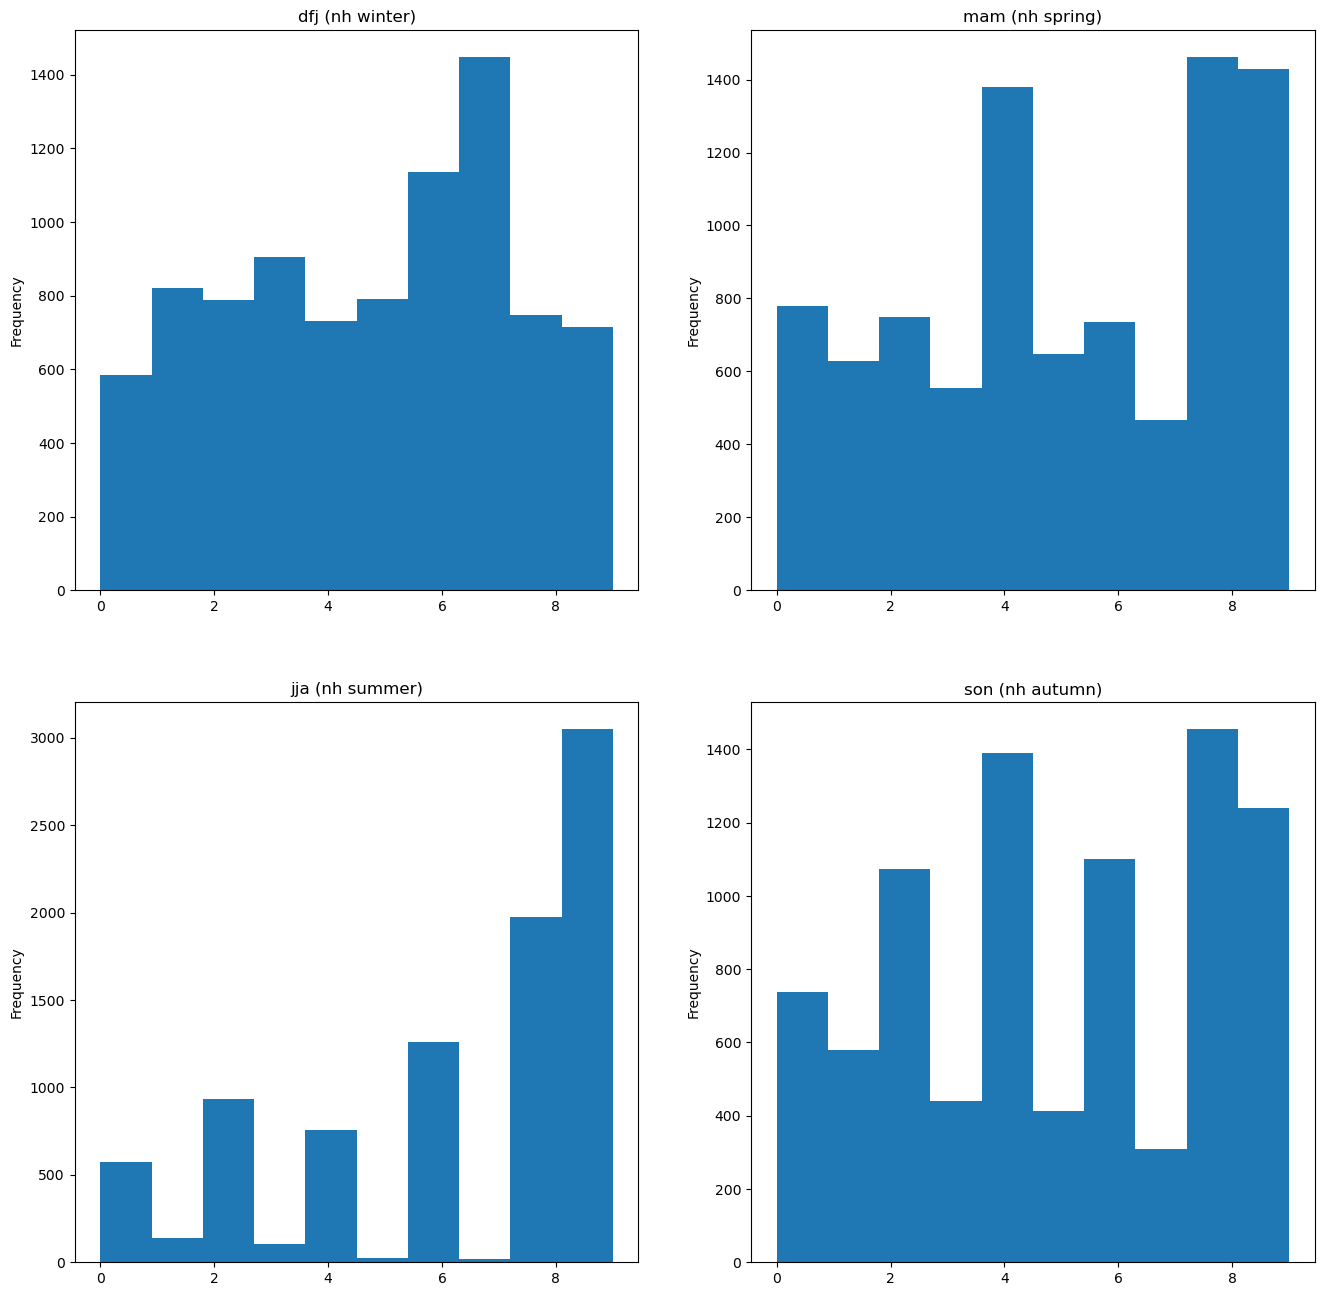

In [145]:
fig1 = matplotlib.pyplot.figure(figsize=(16,16))
for sn1, current_season in enumerate(season_clusters_pca):
    ax1 = fig1.add_subplot(2,2,sn1+1, title=season_names[sn1])
    pandas.Series(current_season).plot.hist(ax=ax1)
    

### Saving the model

Here we could very easily save the key parts of the steps and recreate them, to predict clusters on other data using our training outputs.
* The seasonal means
* The cluster centres
* The PCA transforms

In [146]:
pca_mslp.singular_values_

array([14662625.   ,  8368674.   ,  4803811.5  ,  3206283.8  ,
        2613855.2  ,  1565799.5  ,  1386962.6  ,  1142470.9  ,
         954315.6  ,   861202.   ,   745312.2  ,   609653.8  ,
         557112.4  ,   538699.94 ,   454949.66 ,   447701.2  ,
         397193.78 ,   359990.47 ,   351121.34 ,   330920.7  ,
         321328.28 ,   270500.47 ,   250725.06 ,   243101.7  ,
         235520.95 ,   224388.94 ,   206088.81 ,   203427.38 ,
         196714.45 ,   187227.11 ,   175636.66 ,   172804.67 ,
         165626.75 ,   153026.23 ,   146490.62 ,   142709.28 ,
         137557.22 ,   134297.67 ,   130902.7  ,   125347.65 ,
         120279.93 ,   114934.62 ,   113605.18 ,   110202.73 ,
         108353.734,   103143.33 ,   100753.   ,    99133.14 ,
          95976.16 ,    93734.414], dtype=float32)

In [147]:
pca_mslp.get_covariance().shape

(8181, 8181)

### Autoencoder and Latent Space K-Means

**UNDER CONSTRUCTION**

Exploring

## Problem 3 - Precipitaton prediction (Regression)

Now we will look at a pipeline for predicting precipitation, based on the *Precipitation Rediagnosis* dataset.

This code is taken from the [repository for the Preciptation Rediagnosis project](https://github.com/informatics-lab/precip_rediagnosis/).


In [12]:
bands = {
    '0.0':[0, 0.01],
    '0.25':[0.01, 0.5], 
    '2.5': [0.5, 4], 
    '7.0':[4, 10], 
    '10.0':[10,220]
}

In [2]:
intensity_band_template = '{source}_fraction_in_band_instant_{band_centre}'

In [3]:
target_parameter = [intensity_band_template.format(source='radar', band_centre=threshold) for threshold in bands.keys()]
nwp_comparison = [intensity_band_template.format(source='mogrepsg', band_centre=threshold) for threshold in bands.keys()]

profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction', 'cloud_volume_fraction'] #'air_pressure',
single_lvl_features = []#['surface_altitude']#'thickness_of_rainfall_amount', 'surface_altitude', 'air_pressure_at_sea_level', 'cloud_area_fraction'

In [4]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
    'nwp': nwp_comparison, 
    'metadata': ['time', 'realization', 'latitude', 'longitude']
} 


### Data Loading & Cleaning

In [13]:
try:
    prd_data_dir = pathlib.Path(os.environ['ML_TUTORIAL_DIR']) / 'prd'
except KeyError:
    prd_data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis/train_202212')
print(prd_data_dir.is_dir())
prd_data_dir

True


PosixPath('/Users/stephen.haddad/data/ml_weather_tutorial/prd')

In [14]:
prd_prefix_str = 'prd_merged'
prd_csv_suffix = 'csv'

In [15]:
prd_path_list = [p1 for p1 in prd_data_dir.rglob(f'{prd_prefix_str}*{prd_csv_suffix}')]
prd_path_list

[PosixPath('/Users/stephen.haddad/data/ml_weather_tutorial/prd/202008_storm_ellen/prd_merged_20200819T0600Z_20200822T1200Z.csv'),
 PosixPath('/Users/stephen.haddad/data/ml_weather_tutorial/prd/202002_storm_dennis/prd_merged_20200214T1800Z_20200217T1800Z.csv'),
 PosixPath('/Users/stephen.haddad/data/ml_weather_tutorial/prd/202002_storm_ciara/prd_merged_20200207T1800Z_20200210T1800Z.csv')]

We will use two of the scenarios for training and reserve one scenario for testing.

In [16]:
prd_train_df = pandas.concat([pandas.read_csv(p1) for p1 in prd_path_list[:-1]])

In [17]:
prd_train_df

,realization,latitude,longitude,forecast_period,forecast_reference_time,time,cloud_area_fraction,surface_altitude,air_pressure_at_sea_level,rainfall_rate,...,radar_fraction_in_band_aggregate_3hr_0.0,radar_fraction_in_band_aggregate_3hr_0.25,radar_fraction_in_band_aggregate_3hr_2.5,radar_fraction_in_band_aggregate_3hr_7.0,radar_fraction_in_band_aggregate_3hr_10.0,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
0,0,49.40625,-5.484375,0 days 06:00:00,2020-08-19,2020-08-19 06:00:00,1.000000,0.0,99658.0,0.013411,...,1.0,0.0,0.0,0.0,0.0,0.964706,0.035294,0.0,0.0,0.0
1,1,49.40625,-5.484375,0 days 06:00:00,2020-08-19,2020-08-19 06:00:00,1.000000,0.0,99762.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.964706,0.035294,0.0,0.0,0.0
2,2,49.40625,-5.484375,0 days 06:00:00,2020-08-19,2020-08-19 06:00:00,0.968750,0.0,99717.0,0.013411,...,1.0,0.0,0.0,0.0,0.0,0.964706,0.035294,0.0,0.0,0.0
3,3,49.40625,-5.484375,0 days 06:00:00,2020-08-19,2020-08-19 06:00:00,1.000000,0.0,99538.0,0.013411,...,1.0,0.0,0.0,0.0,0.0,0.964706,0.035294,0.0,0.0,0.0
4,4,49.40625,-5.484375,0 days 06:00:00,2020-08-19,2020-08-19 06:00:00,1.000000,0.0,99581.0,0.301748,...,1.0,0.0,0.0,0.0,0.0,0.964706,0.035294,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347251,13,58.78125,1.546875,0 days 06:00:00,2020-02-17 12:00:00,2020-02-17 18:00:00,0.953125,0.0,98756.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0
347252,14,58.78125,1.546875,0 days 06:00:00,2020-02-17 12:00:00,2020-02-17 18:00:00,0.968750,0.0,98725.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0
347253,15,58.78125,1.546875,0 days 06:00:00,2020-02-17 12:00:00,2020-02-17 18:00:00,1.000000,0.0,98737.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0
347254,16,58.78125,1.546875,0 days 06:00:00,2020-02-17 12:00:00,2020-02-17 18:00:00,0.984375,0.0,98752.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0


### Feauture Engineering


In [30]:
prd_input_feature_names  = [c1 for c1 in prd_train_df.columns if 'temp' in c1] + [c1 for c1 in prd_train_df.columns if 'humid' in c1]

In [28]:
prd_target_feature_name = 'rainfall_rate'

In [27]:
prd_train_df[prd_input_features]

air_temperature_5.0         302.625000
air_temperature_10.0        302.250000
air_temperature_20.0        302.125000
air_temperature_30.0        302.187500
air_temperature_50.0        302.250000
                               ...    
relative_humidity_4000.0      1.025391
relative_humidity_4500.0      1.023438
relative_humidity_5000.0      1.019531
relative_humidity_5500.0      1.015625
relative_humidity_6000.0      1.010742
Length: 66, dtype: float64

In [31]:
prd_train_df[prd_target_feature_name]

0         0.013411
1         0.000000
2         0.013411
3         0.013411
4         0.301748
            ...   
347251    0.000000
347252    0.000000
347253    0.000000
347254    0.000000
347255    0.000000
Name: rainfall_rate, Length: 721224, dtype: float64

### Data Preparation


In [34]:
prd_preproc_dict = {}
for if1 in prd_input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(prd_train_df[[if1]])
    prd_preproc_dict[if1] = scaler1

In [36]:
prd_target_scaler = sklearn.preprocessing.MinMaxScaler()
prd_target_scaler.fit(prd_train_df[[prd_target_feature_name]])


MinMaxScaler()

In [40]:
prd_X_train = preproc_input(prd_train_df, prd_preproc_dict)
prd_y_train = prd_target_scaler.transform(prd_train_df[[prd_target_feature_name]])

In [41]:
prd_X_train.shape, prd_y_train.shape

((721224, 66), (721224, 1))

In [32]:
prd_test_df = pandas.concat([pandas.read_csv(p1) for p1 in prd_path_list[-1:]])

In [ ]:
# normalise temp and humidity features

In [33]:
prd_test_df

,realization,latitude,longitude,forecast_period,forecast_reference_time,time,cloud_area_fraction,surface_altitude,air_pressure_at_sea_level,rainfall_rate,...,radar_fraction_in_band_aggregate_3hr_0.0,radar_fraction_in_band_aggregate_3hr_0.25,radar_fraction_in_band_aggregate_3hr_2.5,radar_fraction_in_band_aggregate_3hr_7.0,radar_fraction_in_band_aggregate_3hr_10.0,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
0,0,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,0.984375,0.0,101050.0,0.000000,...,0.0,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
1,1,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,1.000000,0.0,101036.0,0.536442,...,0.0,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
2,2,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,0.984375,0.0,101104.0,0.000000,...,0.0,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
3,3,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,0.843750,0.0,101005.0,0.000000,...,0.0,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
4,4,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,1.000000,0.0,101038.0,0.000000,...,0.0,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347251,13,58.78125,1.546875,0 days 06:00:00,2020-02-10 12:00:00,2020-02-10 18:00:00,1.000000,0.0,96907.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0
347252,14,58.78125,1.546875,0 days 06:00:00,2020-02-10 12:00:00,2020-02-10 18:00:00,0.812500,0.0,96895.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0
347253,15,58.78125,1.546875,0 days 06:00:00,2020-02-10 12:00:00,2020-02-10 18:00:00,0.984375,0.0,96989.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0
347254,16,58.78125,1.546875,0 days 06:00:00,2020-02-10 12:00:00,2020-02-10 18:00:00,1.000000,0.0,96823.0,0.000000,...,1.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0


In [42]:
prd_X_test = preproc_input(prd_test_df, prd_preproc_dict)
prd_y_test = prd_target_scaler.transform(prd_test_df[[prd_target_feature_name]])

In [43]:
prd_X_test.shape, prd_y_test.shape

((347256, 66), (347256, 1))

In [44]:
prd_tuples = [
    (prd_X_train, prd_y_train),
    (prd_X_test, prd_y_test),    
]

### Algorithm Setup

In [47]:
prd_classifiers_params = {
    'random_forest': {'class': sklearn.ensemble.RandomForestRegressor, 'opts': {'max_depth':10, }},
     'ann_5_500': {'class': sklearn.neural_network.MLPRegressor, 'opts': {'hidden_layer_sizes':(500,500,500,500,500)}},   
}

In [48]:
%%time
prd_classifiers_dict = {}             
for clf_name, clf_params in prd_classifiers_params.items():
    clf1 = clf_params['class'](**clf_params['opts'])
    prd_classifiers_dict[clf_name] = clf1

CPU times: user 153 µs, sys: 412 µs, total: 565 µs
Wall time: 573 µs


## Algorithm Training

In [55]:
num_training_samples = 50000

In [52]:
%%time
for clf_name, clf1 in prd_classifiers_dict.items():
    print(clf_name)
    clf1.fit(prd_X_train[:num_training_samples,:], prd_y_train[:num_training_samples])


random_forest
ann_5_500
CPU times: user 3min 58s, sys: 6.17 s, total: 4min 4s
Wall time: 48 s


### Inference

In [53]:
prd_y_pred_train = {}

for clf_name, clf1 in prd_classifiers_dict.items():
    prd_y_pred = clf1.predict(prd_X_train)
    prd_y_pred_train[clf_name] = prd_y_pred
    prd_train_df[f'pred_{clf_name}'] = prd_y_pred

In [54]:
prd_y_pred_test= {}

for clf_name, clf1 in prd_classifiers_dict.items():
    prd_y_pred = clf1.predict(prd_X_test)
    prd_y_pred_test[clf_name] = prd_y_pred
    prd_test_df[f'pred_{clf_name}'] = prd_y_pred

### Evaluation

In [57]:
prd_test_rmse = sklearn.metrics.mean_squared_error(
    prd_y_test,
    prd_classifiers_dict['ann_5_500'].predict(prd_X_test))
prd_test_rmse

0.0027161770393959793

### Caveats for this example

This is a very naive solution to this problem, and it is giving us bad results. This is not a surprise, as precipitation is generally considered a very difficult field to predict using any we will look at a more sophisticated approach in the next notebook.

## Examples of use
* You can see more example notebook relating to this challenge on the [Data Science CoP GitHub repository](https://github.com/MetOffice/data_science_cop/tree/master/challenges/2021_falklands_rotors).

More Information on Weather Patterns can be found here, which the full much more sophisticated technique used in the real application:
* [Met Office Info Page on Weather Types](https://www.metoffice.gov.uk/research/news/2016/new-weather-patterns-for-uk-and-europe)
* [Paper by Neal, Fereday et al.](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/met.1563)
 


## Next steps

* [Rotors Challenge Notebooks](https://github.com/MetOffice/data_science_cop/tree/master/challenges/2021_falklands_rotors) 
* [Leeds University Notebooks](https://cemac.github.io/LIFD_ENV_ML_NOTEBOOKS/) 
* [Kaggle Weather Types Clustering Competition](https://www.kaggle.com/code/prakharrathi25/weather-data-clustering-using-k-means/notebook)


## Dataset Info

### Falklands Rotors Challenge Dataset
Crown Copyright 2021 - This dataset was created by Met Office Chief Operational Meterologist Steve Ramsdale from Met Office forecast and observation data.
* Model Data - Met Office Global 10km resolution model
* Observations - made by meteorologists at Mount Pleasant airfield in the Falkland Islands.

### ERA5
ERA5 is Renanlysis data created by ECMWF. Reanalysis combines observations from many sources. by assimilating these into a forecast model (ECMWF's IFS in this case), to provide a consistent physically valid gridded dataset that is a close to observations as possible
https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5



## References

The format of this notebook is based on the [template for tutorial notebooks](https://github.com/geo-yrao/notebook-dev/blob/main/templates/NCAI_Training_Notebook_template%20-%20Distribution%20Copy.ipynb) developed by NOAA, available on GitHub.